In [1]:
import numpy as np 
import scipy.stats as st
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter  
import torch.nn as nn
import torch.functional as F
import torch.optim as optim
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import auc
import cmprsk.cmprsk as cmprsk
from scipy import integrate
import matplotlib.pyplot as plt
import time
device= "cpu"
torch.set_default_tensor_type(torch.DoubleTensor)
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
def g1(x):
    g = x[:,0] + 2*x[:,1] + 3*x[:,2] + 4*x[:,3] + 5*x[:,4] -15.5
    return g
def g2(x):
    g = (x[:,0]**2 + 2*x[:,1]**2 + x[:,2]**3 + torch.sqrt(x[:,3]+1) + torch.log(x[:,4]+1) -8.6)*2
    return g
def g3(x):
    g = (-x[:,0]**2*x[:,1]**3 + 10*torch.log(x[:,2]+1) - torch.sqrt(x[:,3]*x[:,4]+1) + 3*torch.exp(x[:,4]/2)-6.3)*3
    return g
def g4(x):
    g = (-x[:,0]**2*x[:,1]**3 + torch.log(x[:,2]+1) - torch.sqrt(x[:,3]*x[:,4]+1) + torch.exp(x[:,4]/2))**2/20 -6.0+3.63
    return g
#定义非参数部分函数

def inv_func1(beta11,beta12 , g, u, z, x,p):
    '''
    beta: 线性协变量系数
    g:非线性协变量函数
    u:均匀分布随机变量
    z:线性部分协变量
    x:非线性部分协变量
    p:主要事件生成概率
    '''
    hazard = torch.exp(beta11*z[:,0]+beta12*z[:,1]  + g(x))
    y = -torch.log(1-(1-(1-u)**(1/(hazard)))/p)
    return y
#定义主要事件逆概率函数

def inv_func2(beta21,beta22,z,u):
    '''
    beta: 线性协变量系数
    u:均匀分布随机变量
    z:线性部分协变量
    '''
    hazard = torch.exp(beta21*z[:,0]+beta22*z[:,1])
    rate = torch.exp(hazard)
    y = -torch.log(1-u)/rate
    return y
#定义竞争风险事件的逆概率函数
def inv_funcc(a,b,u):
    c=u*(b-a)+a
    return c
#定义删失事件的逆概率函数
def dataproduce(n, beta11, beta12, beta21, beta22, g_index, z_index, seed, p, a, b):
    '''
    n:样本量
    beta:线性协变量系数
    g_index:非线性协变量函数的选择指标
    z_index:线性协变量分布的选择指标
    seed:随机数种子
    mu:删失随机变量参数
    p:生成主要事件概率
    '''
    np.random.seed(seed)
    torch.manual_seed(seed)#设置随机数种子
    sigma = 0.5*torch.ones((5,5)) + 0.5*torch.eye(5)
    mvnorm = st.multivariate_normal(mean=[0,0,0,0,0], cov=sigma)#定义Gaussian copula
    X = torch.from_numpy(2*st.norm.cdf(mvnorm.rvs(n)))
    if z_index==1:
        Z = torch.randint(2,size = [2*n])
    else:
        Z = torch.randn(2*n)/torch.sqrt(torch.tensor([2.0]))+0.5#生成线性协变量
    Z = Z.reshape(n,2)
    if g_index==1:
        g = g1
    if g_index==2:
        g = g2
    if g_index==3:
        g = g3
    if g_index==4:
        g = g4
    #选择函数g
    u =  torch.rand(n)
    t = inv_func1(beta11, beta12, g, u, Z, X,p)#生成事件发生时间
    index2=~(t>0)
    n2=int(sum(index2))
    #确定竞争风险事件的指标集和样本量
    u=torch.rand(n2)
    t2=inv_func2(beta21,beta22,Z[index2],u)
    #生成竞争风险事件的数据
    t[index2]=t2
    epsilon = torch.zeros(n)
    epsilon[index2] = 1
    epsilon = epsilon+1
    #得出事件类型指标
    u = torch.rand(n)
    C = inv_funcc(a,b,u)
    delta = (C >= t)+0.0
    t = torch.minimum(t,C)
    return t.reshape(n,1),epsilon.reshape(n,1),Z.reshape(n,2),X,delta.reshape(n,1)
#定义数据生成函数

def likelihood(t, epsilon, Z, beta, g, delta,G_hat):
    n = len(epsilon)
    t_re = t.reshape((n,1))
    epsilon_re = epsilon.reshape((n,1))
    G = G_hat/G_hat.T
    G[torch.isnan(G)] = 0
    G[torch.isinf(G)] =-0
    R1 = t_re@torch.ones((1,n)).to(device) <= (t_re@torch.ones((1,n)).to(device)).T
    R2 = torch.minimum(t_re@torch.ones((1,n)).to(device) >= (t_re@torch.ones((1,n)).to(device)).T,torch.ones((n,1)).to(device)@(epsilon_re-1).T)
    R2 = torch.minimum(R2,torch.ones((n,1)).to(device)@(delta).T)*G
    R = torch.maximum(R1,R2)
    beta = beta.reshape((len(beta),1))
    g = g.reshape((n,1))
    l = torch.sum(((2-epsilon_re[delta ==1])*((Z@beta)[delta ==1]+(g)[delta ==1]-torch.log((R@torch.exp(Z@beta+g))[delta ==1]))))
    return l
#定义似然函数
def dedata(data):
    T = data[:,0:1]
    epsilon = data[:,1:2]
    Z = data[:,2:4]
    X = data[:,4:9]
    delta = data[:,9:]
    return T,epsilon,Z,X,delta
#将整个数据集分成list
def cv(data,seed):
    train,test = train_test_split(data, train_size=0.80, test_size=0.20,random_state=seed)
    train,valid = train_test_split(train, train_size=0.80, test_size=0.20,random_state=seed)
    return train,valid,test
#划分训练集，验证集，测试集
def G_hat(T,delta):
    kmf = KaplanMeierFitter()
    kmf.fit(T, event_observed=1-delta)
    km = kmf.survival_function_["KM_estimate"]
    return torch.tensor(km.loc[T[:,0]].values.reshape(len(T[:,0]),1)).to(device)
#定义删失变量的估计值

def likelihood_linear(t, epsilon, Z, X, beta, gamma,delta,G_hat):
    n = len(epsilon)
    t_re = t.reshape((n,1))
    epsilon_re = epsilon.reshape((n,1))
    G = G_hat/G_hat.T
    G[torch.isnan(G)] = 0
    G[torch.isinf(G)] =-0
    R1 = t_re@torch.ones((1,n)).to(device) <= (t_re@torch.ones((1,n)).to(device)).T
    R2 = torch.minimum(t_re@torch.ones((1,n)).to(device) >= (t_re@torch.ones((1,n)).to(device)).T,torch.ones((n,1)).to(device)@(epsilon_re-1).T)
    R2 = torch.minimum(R2,torch.ones((n,1)).to(device)@(delta).T)*G
    R = torch.maximum(R1,R2)
    beta = beta.reshape((len(beta),1))
    gamma = gamma.reshape((len(gamma),1))
    l = torch.sum(((2-epsilon_re[delta ==1])*((Z@beta)[delta ==1]+(X@gamma)[delta ==1]-torch.log((R@torch.exp(Z@beta+X@gamma))[delta ==1]))))
    return l
#定义fine and gray model对应的似然函数

class Net_linear(nn.Module):
    def __init__(self):
        super(Net_linear,self).__init__()
        self.beta=nn.Parameter(torch.zeros(2).to(device),requires_grad=True)
        self.gamma = nn.Parameter(torch.zeros(5).to(device),requires_grad=True)
#定义fine and gray model对应的优化网络
        
class Myloss_linear(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, t, epsilon, Z, X, beta, gamma,delta,G_hat):
        return -likelihood_linear(t, epsilon, Z, X, beta,gamma,delta,G_hat)
#定义fine and gray model对应的损失函数

       
def beta0(data,G_hat_train,G_hat_valid):
    train, valid, test = cv(data,1)
    T_train,epsilon_train,Z_train,X_train,delta_train=dedata(train)
    T_valid,epsilon_valid,Z_valid,X_valid,delta_valid=dedata(valid)
    model  = Net_linear().to(device)
    criterion = Myloss_linear()
    optimizer=optim.SGD(model.parameters(),lr=0.01)
    model.train()
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    for j in range(int(5e2)):
        optimizer.zero_grad()
        loss=criterion(T_train,epsilon_train,Z_train,X_train, model.beta,model.gamma,delta_train,G_hat_train)
        loss2 = criterion(T_valid,epsilon_valid,Z_valid,X_valid, model.beta,model.gamma,delta_valid,G_hat_valid)
        loss1 = torch.min(loss1,loss2)
        if loss2-loss1 > 1e-5:
            break
        if loss1 >0:
            0
        else:
            break
        loss1 = loss2
        loss.backward()
        optimizer.step()
    return model.beta
#定义参数部分初始化函数
class Net1(nn.Module):
    def __init__(self,beta_0):
        super(Net1,self).__init__()
        self.module=nn.Sequential(
            nn.Linear(4,10),nn.ReLU(),
            nn.Linear(10,1))
        self.beta=nn.Parameter(beta_0 ,requires_grad=True)
    def forward(self,x):
        x=self.module(x)
        return x
class Net2(nn.Module):
    def __init__(self,beta_0):
        super(Net2,self).__init__()
        self.module=nn.Sequential(
            nn.Linear(4,10),nn.ReLU(),
            nn.Linear(10,40),nn.ReLU(),
            nn.Linear(40,40),nn.ReLU(),
            nn.Linear(40,20),nn.ReLU(),
            nn.Linear(20,10),nn.ReLU(),
            nn.Linear(10,1))
        self.beta=nn.Parameter(beta_0 ,requires_grad=True)
    def forward(self,x):
        x=self.module(x)
        return x
class Net3(nn.Module):
    def __init__(self,beta_0):
        super(Net3,self).__init__()
        self.module = nn.Sequential(
            nn.Sequential(nn.Linear(4,10), nn.ReLU()),
            nn.Sequential(nn.Linear(10,40), nn.ReLU(), nn.Dropout(0.3)),
            nn.Sequential(nn.Linear(40,40), nn.ReLU(), nn.Dropout(0.3)),
            nn.Sequential(nn.Linear(40,40), nn.ReLU(), nn.Dropout(0.3)),
            nn.Sequential(nn.Linear(40,40), nn.ReLU(), nn.Dropout(0.3)),
            nn.Sequential(nn.Linear(40,20), nn.ReLU(), nn.Dropout(0.3)),
            nn.Sequential(nn.Linear(20,10), nn.ReLU(), nn.Dropout(0.3)),
            nn.Sequential(nn.Linear(10,1))
        )
        self.beta=nn.Parameter(beta_0 ,requires_grad=True)
    def forward(self,x):
        x=self.module(x)
        return x
class Net4(nn.Module):
    def __init__(self,beta_0):
        super(Net4,self).__init__()
        self.module = nn.Sequential(
            nn.Linear(4, 300),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(300, 300),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(300, 1)
        )
        self.beta=nn.Parameter(beta_0 ,requires_grad=True)
    def forward(self,x):
        x=self.module(x)
        return x
#定义DNN结构

class MyLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, T,epsilon,Z ,beta ,g,delta,G_hat):
        return -likelihood(T,epsilon,Z,beta ,g,delta,G_hat)
#定义损失函数

def chooseNet(index,beta_0):
    if index ==1:
        model=Net1(beta_0 = beta_0)
        lr = 5e-2
    if index ==2:
        model=Net2(beta_0 = beta_0)
        lr = 1e-3
    if index ==3:
        model=Net3(beta_0 = beta_0)
        lr = 1e-3
    if index ==4:
        model=Net4(beta_0 = beta_0)
        lr = 5e-4
    return model.to(device),lr
#定义网络选择函数
def REg(g_0, g_hat):
    g_hat=g_hat.reshape([len(g_0),])
    y = torch.sqrt(torch.mean(((g_hat-torch.mean(g_hat))-g_0)**2)/(torch.mean((g_0)**2)))
    return y
class h_net(nn.Module):
    def __init__(self):
        super(h_net, self).__init__()
        self.module=nn.Sequential(
            nn.Linear(1,5),nn.ReLU(),
            nn.Linear(5,10),nn.ReLU(),
            nn.Linear(10,10),nn.ReLU(),
            nn.Linear(10,5),nn.ReLU(),
            nn.Linear(5,1),)
    def forward(self,x):
        x=self.module(x)
        return x 

class g_net(nn.Module):
    def __init__(self):
        super(g_net, self).__init__()
        self.module=nn.Sequential(
            nn.Linear(4,10),nn.ReLU(),
            nn.Linear(10,40),nn.ReLU(),
            nn.Linear(40,40),nn.ReLU(),
            nn.Linear(40,20),nn.ReLU(),
            nn.Linear(20,10),nn.ReLU(),
            nn.Linear(10,1))
    def forward(self,x):
        x=self.module(x)
        return x
def VE_loss_func(epsilon,delta,Z,h,g):
    l = torch.mean((2-epsilon)*delta*(Z-h-g)**2)
    return l
class VE_loss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, epsilon,delta,Z,h,g):
        return VE_loss_func(epsilon,delta,Z,h,g)
    
def estimation(Net_index, train, valid, test,G_hat_train,G_hat_valid,G_hat_train0,G_hat_valid0,g):
    window = []
    positive = 0
    T_train,epsilon_train,Z_train,X_train,delta_train=dedata(train)
    T_test,epsilon_test,Z_test,X_test,delta_test=dedata(test)
    T_valid,epsilon_valid,Z_valid,X_valid,delta_valid=dedata(valid)
    beta_0 = beta0(train,G_hat_train0,G_hat_valid0)
    '''
    model = Net(beta_0=beta_0)
    criterion = MyLoss()
    lr = 1e-3
    optimizer = torch.optim.Adam([{'params':model.module.parameters(),'lr':lr},
                                {'params':model.beta,'lr':50*lr}])
    '''
    model,lr = chooseNet(Net_index,beta_0)
    criterion = MyLoss()
    optimizer = torch.optim.Adam([{'params':model.module.parameters(),'lr':lr},
                                {'params':model.beta,'lr':50*lr}])
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    loss3 = (torch.tensor(1e5))
    loss4 = (torch.tensor(1e6))
    for j in range(int(1000)):
        optimizer.zero_grad()
        g_train = model(X_train)
        loss=criterion(T_train,epsilon_train,Z_train,model.beta ,g_train,delta_train,G_hat_train)
        loss1 = loss
        if torch.isnan(loss2):
            break
        g_valid = model(X_valid)
        loss2 = criterion(T_valid,epsilon_valid,Z_valid,model.beta ,g_valid,delta_valid,G_hat_valid)
        g_test = model(X_test)
        loss3 = criterion(T_valid,epsilon_valid,Z_valid,model.beta ,g_valid,delta_valid,G_hat_valid)
        loss4 = torch.min(loss3,loss4)
        window.append(loss2)
        d = 10
        if j >100:
            criterion_set = torch.mean(torch.tensor(window)[j-d:j]-torch.tensor(window)[j-d-1:j-1])
            if criterion_set>0:
                positive = positive+1
                if loss3 - loss4 > 0.015*torch.abs(loss4):
                    break
                if positive > 50:
                    break
        loss.backward()
        optimizer.step()
    return loss2, model.beta[0], model.beta[1], REg(g(X_test),g_test),g_test,model


def variance_estimation(train, valid, test):
    criterion_ve = VE_loss()
    T_train,epsilon_train,Z_train,X_train,delta_train=dedata(train)
    T_test,epsilon_test,Z_test,X_test,delta_test=dedata(test)
    T_valid,epsilon_valid,Z_valid,X_valid,delta_valid=dedata(valid)
    h_net_1=h_net().to(device)
    h_net_2=h_net().to(device)
    g_net_1=g_net().to(device)
    g_net_2=g_net().to(device)
    optimizer_1 = torch.optim.Adam(list(h_net_1.parameters())+list(g_net_1.parameters()), lr=0.001)
    h_net_1.train()
    g_net_1.train()
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    for j in range(int(1e4)):
        optimizer_1.zero_grad()
        loss = criterion_ve(epsilon_train, delta_train, Z_train[:,[0]], h_net_1(T_train), g_net_1(X_train))
        loss2 = criterion_ve(epsilon_valid, delta_valid, Z_valid[:,[0]], h_net_1(T_valid), g_net_1(X_valid))
        loss1 = torch.min(loss1,loss2)
        if loss2-loss1 > (0.04)*torch.abs(loss1):
            break
        if loss1 >0:
            0
        else:
            break
        loss1 = loss2
        loss.backward()
        optimizer_1.step()
    optimizer_2 = torch.optim.Adam(list(h_net_2.parameters())+list(g_net_2.parameters()), lr=0.001)
    h_net_2.train()
    g_net_2.train()
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    for j in range(int(1e4)):
        optimizer_2.zero_grad()
        loss = criterion_ve(epsilon_train, delta_train, Z_train[:,[1]], h_net_2(T_train), g_net_2(X_train))
        loss2 = criterion_ve(epsilon_valid, delta_valid, Z_valid[:,[1]], h_net_2(T_valid), g_net_2(X_valid))
        loss1 = torch.min(loss1,loss2)
        if loss2-loss1 > (0.04)*torch.abs(loss1):
            break
        if loss1 >0:
            0
        else:
            break
        loss1 = loss2
        loss.backward()
        optimizer_2.step()
    a = torch.mean((2-epsilon_train)*delta_train*(Z_train[:,[0]]-h_net_1(T_train)-g_net_1(X_train))**2)
    b = torch.mean((2-epsilon_train)*delta_train*(Z_train[:,[0]]-h_net_1(T_train)-g_net_1(X_train))*(Z_train[:,[1]]-h_net_2(T_train)-g_net_2(X_train)))
    c = b 
    d = torch.mean((2-epsilon_train)*delta_train*(Z_train[:,[1]]-h_net_2(T_train)-g_net_2(X_train))**2)
    std1 = torch.sqrt(d/(a*d-b*c))
    std2 = torch.sqrt(a/(a*d-b*c))
    return std1,std2
def CI_cover(n,estimation, std, parameter):
    n = torch.tensor(n)
    cover = 0
    if (estimation-1.96*std/torch.sqrt(n)<= parameter)&(estimation+1.96*std/torch.sqrt(n)>= parameter):
        cover = cover+1
    return cover
def riskmatrix(epsilon,T,delta,G_hat):
    n = len(epsilon)
    t_re = T.reshape((n,1))
    epsilon_re = epsilon.reshape((n,1))
    G = G_hat/G_hat.T
    G[torch.isnan(G)] = 0
    G[torch.isinf(G)] =-0
    R1 = t_re@(torch.ones((1,n))).to(device) <= (t_re@torch.ones((1,n)).to(device)).T
    R2 = torch.minimum(t_re@torch.ones((1,n)).to(device) >= (t_re@torch.ones((1,n)).to(device)).T,torch.ones((n,1)).to(device)@(epsilon_re-1).T)
    R2 = torch.minimum(R2,torch.ones((n,1)).to(device)@(delta).T)*G
    R = torch.maximum(R1,R2)
    return R
def riskmatrix_add(epsilon,T,delta,G_hat):
    n = len(epsilon)
    t_re = T.reshape((n,1))
    epsilon_re = epsilon.reshape((n,1))
    G = G_hat/G_hat.T
    G[torch.isnan(G)] = 0
    G[torch.isinf(G)] =-0
    R1 = t_re@torch.ones((1,n)).to(device) < (t_re@torch.ones((1,n)).to(device)).T
    R2 = torch.minimum(t_re@torch.ones((1,n)).to(device) >= (t_re@torch.ones((1,n)).to(device)).T,torch.ones((n,1)).to(device)@(epsilon_re-1).T)
    R2 = torch.minimum(R2,torch.ones((n,1)).to(device)@(delta).T)*G
    R = torch.maximum(R1,R2)
    return R
def TP(R,M):
    n = len(M)
    expM_vector = torch.exp(M).reshape(1,n)
    Y_expM_matrix = R*expM_vector#列时间变化，行样本变化
    M_order_matrix = (M.reshape(n,1)>M.reshape(1,n)).double()
    Numerator = Y_expM_matrix@M_order_matrix#T,M
    Denominator = Y_expM_matrix@torch.ones((n,n)).to(device)
    TP  = Numerator/Denominator
    return TP
def FP(R_add,M):
    n = len(M)
    M_order_matrix = (M.reshape(n,1)>M.reshape(1,n)).double()
    Numerator = R_add@M_order_matrix#T,M
    Denominator = R_add@torch.ones((n,n)).to(device)
    Denominator[Denominator==0]=1
    FP = Numerator/Denominator
    return FP
def auc_t(M,TPR,FPR):
    n = len(M)
    auc_array = torch.zeros(n)
    for i in range(n):
        sorted_index = torch.argsort(FPR[i])
        fpr_list_sorted =  torch.tensor(FPR[i])[sorted_index]
        tpr_list_sorted = torch.tensor(TPR[i])[sorted_index]
        auc_array[i] = integrate.trapz(y=tpr_list_sorted, x=fpr_list_sorted)
    return auc_array
def Stof(S,t):
    index = torch.argsort(t[:,0])
    t_ordered = t[index]
    S_ordered = S[index]
    f = (torch.concatenate((torch.ones((1,len(S_ordered))).to(device), S_ordered[:-1])) -S_ordered )/(t_ordered- torch.concatenate((torch.tensor([[0]]).to(device), t_ordered[:-1])))
    return fill_nan(torch.mean(f,axis = 1))
def Gamma_hat(t, epsilon, Z,beta, g, delta,G_hat):
    n = len(epsilon)
    t_re = t.reshape((n,1))
    epsilon_re = epsilon.reshape((n,1))
    G = G_hat/G_hat.T
    G[torch.isnan(G)] = 0
    G[torch.isinf(G)] =-0
    R1 = t_re@torch.ones((1,n)).to(device) <= (t_re@torch.ones((1,n)).to(device)).T
    R2 = torch.minimum(t_re@torch.ones((1,n)).to(device) >= (t_re@torch.ones((1,n)).to(device)).T,torch.ones((n,1)).to(device)@(epsilon_re-1).T)
    R2 = torch.minimum(R2,torch.ones((n,1).to(device)@(delta).T))*G
    R = torch.maximum(R1,R2)
    beta = beta.reshape((len(beta),1))
    g = g.reshape((n,1))
    S=(R@torch.exp(Z@beta+g))/n
    Gamma = ((t>=(t.T)).double()@((2-epsilon)*delta/S))/n
    return Gamma
def f_hat(t, epsilon, Z,beta, g, delta):
    Gamma = Gamma_hat(t, epsilon, Z,beta, g, delta)
    n = len(epsilon)
    beta = beta.reshape((len(beta),1))
    g = g.reshape((n,1))
    S = torch.exp(-(Gamma)@torch.exp(Z@beta+g).T)
    f = Stof(S,t)
    return torch.mean(f,axis = 1)
def S_hat(t, epsilon, Z,beta, g, delta):
    Gamma = Gamma_hat(t, epsilon, Z,beta, g, delta)
    n = len(epsilon)
    beta = beta.reshape((len(beta),1))
    g = g.reshape((n,1))
    S = torch.exp(-(Gamma)@torch.exp(Z@beta+g).T)
    index = torch.argsort(t[:,0])
    S_ordered = S[index]
    return torch.mean(S_ordered,axis = 1)
def Gamma_real(t,p):
    Gamma = -torch.log(1-p*(1-torch.exp(-t)))
    return Gamma
def f_real(t,  Z,beta, g, p):
    n = len(t)
    Gamma = Gamma_real(t, p)
    beta = beta.reshape((len(beta),1))
    g = g.reshape((len(g),1))
    S = torch.exp(-(Gamma)@torch.exp(Z@beta+g).T)
    f = Stof(S,t)
    return f
def S_real(t,  Z,beta, g, p):
    n = len(t)
    Gamma = Gamma_real(t, p)
    beta = beta.reshape((len(beta),1))
    g = g.reshape((len(g),1))
    S = torch.exp(-(Gamma)@torch.exp(Z@beta+g).T)
    index = torch.argsort(t[:,0])
    S_ordered = S[index]
    return torch.mean(S_ordered,axis = 1)

def C_tau(auc_array,U,U_ordered, X, Z, g_, p):  
    beta = torch.Tensor([0.5,-0.5]).to(device)
    g = g_(X)
    f = f_real(U.reshape((len(U),1)),  Z,beta, g, p)
    S = S_real(U.reshape((len(U),1)),  Z,beta, g, p)
    t_index = torch.sort(U).indices
    t_ordered = U[t_index]
    sub_index = torch.where(torch.isin(t_ordered, U_ordered))
    w = (2*f*S)[sub_index]
    W = torch.trapz(y=w, x=t_ordered[sub_index])
    w_tau = w/W
    C = torch.trapz(y=auc_array*w_tau, x=t_ordered[sub_index])
    return C
def cubic_spline(q,u,m):#q+4:样条基个数，u输入向量
    T = np.around(np.linspace(0,0.8,q),2)
    n = len(u)
    B = np.zeros((n,q))
    for i in range(n):
        B[i,0] = 1
        B[i,1] = u[i]
        B[i,2] = u[i]**2
        B[i,3] = u[i]**3
        for j in range(q):
            if u[i] > T[j]:
                B[i,j] = (u[i] - T[j])**3
    return B
def outcome_to_df(outcomes,i):
    outcomes_colname = ['beta1', 'beta2', 'REg', 'std1', 'std2', 'cover_rate1', 'cover_rate2', 'AUC(25%)','AUC(50%)','AUC(75%)','C^tau']
    df_outcomes_DP = (pd.DataFrame(np.array(outcomes)[:,i:])).rename(columns=dict(zip((pd.DataFrame(np.array(outcomes)[:,i:])), outcomes_colname)))
    return df_outcomes_DP
def TPR_FPR(U_test,M,M0):
    U_ordered = U_test[(U_test>0)&(U_test<U_test.max())].sort().values
    Y_t = (~(U_test.reshape((len(U_test),1)) < U_ordered.reshape((1,len(U_ordered))))).int().to(device)
    '''
    Y_i(t_j)对应的矩阵(i,j)
    '''
    Yt_eM = Y_t*(torch.exp(M0).reshape((len(M0),1)))
    W_t = Yt_eM.sum(axis =0).reshape((1,len(U_ordered)))
    TPR = ((M.reshape(len(M),1)>M.sort().values.reshape(1,len(M))).double().T)@(Yt_eM/W_t)
    '''
    mi,tj对应(i,j)
    '''
    Y_t_add = (~(U_test.reshape((len(U_test),1)) <= U_ordered.reshape((1,len(U_ordered))))).int().to(device)
    W_t_add = Y_t_add.sum(axis =0).reshape((1,len(U_ordered)))
    FPR = ((M.reshape(len(M),1)>M.sort().values.reshape(1,len(M))).double().T)@(Y_t_add/W_t_add)
    return torch.flip(TPR,[0]),torch.flip(FPR,[0])
def Uproduce(n, beta11, beta12, beta21, beta22, g_index, z_index, seed, p, a, b):
    '''
    n:样本量
    beta:线性协变量系数
    g_index:非线性协变量函数的选择指标
    z_index:线性协变量分布的选择指标
    seed:随机数种子
    mu:删失随机变量参数
    p:生成主要事件概率
    '''
    np.random.seed(seed)
    torch.manual_seed(seed)#设置随机数种子
    sigma = 0.5*torch.ones((5,5)) + 0.5*torch.eye(5)
    mvnorm = st.multivariate_normal(mean=[0,0,0,0,0], cov=sigma)#定义Gaussian copula
    X = torch.from_numpy(2*st.norm.cdf(mvnorm.rvs(n)))
    if z_index==1:
        Z = torch.randint(2,size = [2*n])
    else:
        Z = torch.randn(2*n)/torch.sqrt(torch.tensor([2.0]))+0.5#生成线性协变量
    Z = Z.reshape(n,2)
    if g_index==1:
        g = g1
    if g_index==2:
        g = g2
    if g_index==3:
        g = g3
    if g_index==4:
        g = g4
    #选择函数g
    u =  torch.rand(n)
    t = inv_func1(beta11, beta12, g, u, Z, X,p)#生成事件发生时间
    return t
def fill_nan(arr):
    mask = torch.isnan(arr)
    idx = torch.where(~mask, torch.arange(len(arr)).to(device), -1)
    lenth  = len(arr)
    idx_set= 0
    for i in range(lenth):
        if idx[i] != -1:
            idx_set = idx[i]
        else:
            idx[i] = idx_set
    return arr[idx]   
def estimation_application(batch_size,Net_index, T_train,epsilon_train,Z_train,X_train,delta_train,T_valid,epsilon_valid,Z_valid,X_valid,delta_valid,G_hat_train,G_hat_valid,beta_0):
    window = []
    positive = 0
    '''
    model = Net(beta_0=beta_0)
    criterion = MyLoss()
    lr = 1e-3
    optimizer = torch.optim.Adam([{'params':model.module.parameters(),'lr':lr},
    {'params':model.beta,'lr':50lr}])
    '''
    model,lr = chooseNet(Net_index,beta_0)
    criterion = MyLoss()
    optimizer = torch.optim.Adam([{'params':model.module.parameters(),'lr':lr},
                                {'params':model.beta,'lr':50*lr}])
    loss2 = (torch.tensor(1e6))
    loss3 = (torch.tensor(1e5))
    loss4 = (torch.tensor(1e6))
    batch_index = 0
    sample_size = len(T_train)
    for j in range(int(1000)):
        optimizer.zero_grad()
        batch_index = (batch_size*j)%sample_size
        end_index =  batch_index + batch_size
        X_batch = X_train[batch_index:end_index]
        epsilon_batch  = epsilon_train[batch_index:end_index]
        Z_batch = Z_train[batch_index:end_index]
        T_batch = T_train[batch_index:end_index]
        delta_batch = delta_train[batch_index:end_index]
        G_hat_batch = G_hat_train[batch_index:end_index]
        g_train = model(X_batch)
        loss=criterion(T_batch,epsilon_batch,Z_batch,model.beta ,g_train,delta_batch,G_hat_batch)
        if torch.isnan(loss2):
            break
        g_valid = model(X_valid)
        loss2 = criterion(T_valid,epsilon_valid,Z_valid,model.beta ,g_valid,delta_valid,G_hat_valid)
        loss3 = criterion(T_valid,epsilon_valid,Z_valid,model.beta ,g_valid,delta_valid,G_hat_valid)
        loss4 = torch.min(loss3,loss4)
        window.append(loss2)
        d = 10
        if j >100:
            criterion_set = torch.mean(torch.tensor(window)[j-d:j]-torch.tensor(window)[j-d-1:j-1])
            if criterion_set>0:
                positive = positive+1
                if loss3 - loss4 > 0.015*torch.abs(loss4):
                    break
                if positive > 50:
                    break
        loss.backward()
        optimizer.step()
    return loss2, model.beta[0], model.beta[1],model.beta[2],model.beta[3],model.beta[4],model.beta[5],model.beta[6],model
def Z_normalize(Z_df,nonlinear_variable):
    Z_non = Z_df[nonlinear_variable]
    Z_df[nonlinear_variable] = (Z_non-Z_non.mean())/Z_non.std()
    return Z_df

In [2]:
df = pd.read_excel('kidney data.xlsx')
df['Sex'].replace(['Female', 'Male'],[0, 1], inplace=True)
df['Race recode (W, B, AI, API)'].replace(['White', 'Black','Asian or Pacific Islander','American Indian/Alaska Native'],[0,1,2,2], inplace=True)
df['Grade (thru 2017)'] = df['Grade (thru 2017)'].replace(r'[A-Za-z]', '',regex=True)
df['Grade (thru 2017)'] = df['Grade (thru 2017)'].replace(r';', '',regex=True)
df['Laterality'].replace(['Right - origin of primary', 'Left - origin of primary'],[0,1], inplace=True)
df['SEER cause-specific death classification'].replace(['Alive or dead of other cause', 'Dead (attributable to this cancer dx)'],[0, 1], inplace=True)
df['SEER other cause of death classification'].replace(['Alive or dead due to cancer', 'Dead (attributable to causes other than this cancer dx)'],[0, 2], inplace=True)
df['Vital status recode (study cutoff used)'].replace(['Alive', 'Dead'],[0, 1], inplace=True)
df['Age recode with <1 year olds'] = df['Age recode with <1 year olds'].str[:2].astype(int)/5
df['Grade (thru 2017)'] = df['Grade (thru 2017)'].astype(int)
df['SEER cause-specific death classification'] = df['SEER cause-specific death classification']+df['SEER other cause of death classification']
df['race_white'] = (df['Race recode (W, B, AI, API)'] == 0).astype(int)
df['race_yellow'] = (df['Race recode (W, B, AI, API)'] == 2).astype(int)
df['site_kidney'] = (df['Primary Site'] == 649).astype(int)#649-kidney
df['site_RenalPelvis'] = (df['Primary Site'] == 659).astype(int)#659-renal pelvis肾盂 669-ureter输尿管
df = df.drop(labels='SEER other cause of death classification',axis=1)
df = df.drop(labels='Race recode (W, B, AI, API)',axis=1)
df = df.drop(labels='Primary Site',axis=1)
#数据预处理

In [3]:
linear_variable = ['Age recode with <1 year olds','Sex','race_white','race_yellow','site_kidney','site_RenalPelvis','Laterality']
nonlinear_variable = ['Year of diagnosis','Histologic Type ICD-O-3','Grade (thru 2017)','CS tumor size (2004-2015)']
#确定线性协变量和非线性协变量
df_age_list = []
for i in range(13):
    age_index = i+5
    df_age_list.append((df.loc[df['Age recode with <1 year olds']==age_index]).reset_index().drop(labels='index',axis=1))
#样本分组，按照年龄划分

In [4]:
df_age = pd.concat([df_age_list[9],df_age_list[10], df_age_list[11]])
df_age['Age recode with <1 year olds'] = df_age['Age recode with <1 year olds']-14
train_list = []
test_list = []
for i,j in KFold(n_splits=5,shuffle=True,random_state=0).split(df_age):
    train_list.append(df_age.iloc[i])
    test_list.append(df_age.iloc[j])

In [5]:
AUCmean_linear_list = []
AUCmean_DP_list = []
graph_linear_list = []
graph_DP_list = []
coeffcient_linear_list = []
coeffcient_DP_list = []
std_linear_list = []
std_DP_list = []
time_list = []
for k in range(5):
    Z_df = train_list[k].iloc[:,3:]
    Z2_df = Z_normalize(Z_df,nonlinear_variable)
    linear_model = cmprsk.crr(failure_time = train_list[k]['Survival months'],failure_status = train_list[k]['SEER cause-specific death classification'],static_covariates =Z2_df, failcode=1, cencode=0)
    coeffcient_linear_list.append(linear_model.summary['coefficients'][linear_variable])
    std_linear_list.append(linear_model.summary['std'][linear_variable])
    TP_list = []
    FP_list = []
    auc_list = []
    df_test = test_list[k]
    Z_test_df = df_test.iloc[:,3:]
    Z2_test_df = Z_normalize(Z_test_df,nonlinear_variable)
    n = len(df_test) 
    T  =  torch.tensor(df_test['Survival months'].values).reshape((n,1)).double()
    Delta  =  torch.tensor(df_test['Vital status recode (study cutoff used)'].values).reshape((n,1)).double()
    epsilon = torch.tensor(df_test['SEER cause-specific death classification'].values).reshape((n,1)).double()
    Z = torch.tensor(np.array(Z2_test_df)).double()
    G_hat_i = G_hat(T,Delta)
    model = linear_model
    T_g = T.to(device)
    Delta_g = Delta.to(device)
    epsilon_g = epsilon.to(device)
    Z_g =Z.to(device) 
    M = Z_g@torch.tensor(model.summary.coefficients.values).to(device)
    R = riskmatrix(epsilon_g, T_g, Delta_g, G_hat_i)
    R_add = riskmatrix_add(epsilon_g, T_g, Delta_g, G_hat_i)
    TP_i = TP(R,M)
    FP_i = FP(R_add,M)
    TP_list.append(TP_i)
    FP_list.append(FP_i)
    auc_array = torch.zeros(n).to(device)
    for j in range(n):
        auc_array[j]=torch.trapz(y=-(-TP_list[0][j]).sort().values, x=FP_list[0][j].sort().values)
    auc_array = auc_array[(epsilon!=2)[:,0]]
    auc_list.append(auc_array)
    auc_mean_array = []
    for i in torch.unique(T[epsilon!=2]).sort().values:
        auc_mean = auc_array[T[epsilon!=2]==i].mean()
        auc_mean_array.append(auc_mean)
    T_U = T[epsilon!=2]
    Delta_U = Delta[epsilon!=2]
    kmf = KaplanMeierFitter()
    kmf.fit(T_U, event_observed=Delta_U)
    S_h = kmf.survival_function_['KM_estimate']
    np.array(S_h)
    S_h_add = np.ones(len(S_h))
    S_h_add[1:] = np.array(S_h)[:(len(S_h)-1)] 
    time_add = -np.ones(len(S_h))
    time_add[1:] = np.array(S_h.index)[:(len(S_h.index)-1)] 
    kmf.survival_function_['f_h'] = (S_h_add - np.array(S_h))/(np.array(S_h.index)-time_add)
    #f_hat and S_hat
    w = np.array(kmf.survival_function_['f_h']*kmf.survival_function_['KM_estimate'])
    w_tau = w/w.sum()
    auc_tau = w_tau*np.array(auc_mean_array)
    C_tau_linear = np.trapz(x = np.array(S_h.index),y = auc_tau)
    time_list.append(np.array(S_h.index))
    graph_linear_list.append(torch.tensor(auc_mean_array).detach().numpy())
    AUCmean_linear_list.append(C_tau_linear)
    df_i = train_list[k]
    train = df_i.sample(frac=0.8, random_state=0)
    valid = df_i.drop(train.index)
    Cov_train_df = Z2_df.sample(frac=0.8, random_state=0)
    Cov_valid_df = Z2_df.drop(Cov_train_df.index)
    Z_train_df = Cov_train_df.loc[:,linear_variable]
    Z_valid_df = Cov_valid_df.loc[:,linear_variable]
    X_train_df = Cov_train_df.loc[:,nonlinear_variable]
    X_valid_df = Cov_valid_df.loc[:,nonlinear_variable]
    beta_0 = torch.tensor(np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])).to(device)
    #划分训练集和验证集，线性协变量和非线性协变量
    ntrain = len(train)
    T_train  =  torch.tensor(train['Survival months'].values).reshape((ntrain,1)).double()
    Delta_train  =  torch.tensor(train['Vital status recode (study cutoff used)'].values).reshape((ntrain,1)).double()
    epsilon_train = torch.tensor(train['SEER cause-specific death classification'].values).reshape((ntrain,1)).double()
    Z_train = torch.tensor(np.array(Z_train_df)).double()
    X_train = torch.tensor(np.array(X_train_df)).double()
    nvalid = len(valid)
    T_valid  =  torch.tensor(valid['Survival months'].values).reshape((nvalid,1)).double()
    Delta_valid  =  torch.tensor(valid['Vital status recode (study cutoff used)'].values).reshape((nvalid,1)).double()
    epsilon_valid = torch.tensor(valid['SEER cause-specific death classification'].values).reshape((nvalid,1)).double()
    Z_valid = torch.tensor(np.array(Z_valid_df)).double()
    X_valid = torch.tensor(np.array(X_valid_df)).double()
    G_hat_train = G_hat(T_train,Delta_train)
    G_hat_valid = G_hat(T_valid,Delta_valid)
    #dp method训练前数据处理
    loss_kk = []
    beta1_kk = []
    beta2_kk = []
    beta3_kk = []
    beta4_kk = []
    beta5_kk = []
    beta6_kk = []
    beta7_kk = []
    model_kk = []
    T_train = T_train.to(device)
    epsilon_train = epsilon_train.to(device)
    Z_train = Z_train.to(device)
    X_train = X_train.to(device)
    Delta_train = Delta_train.to(device)
    T_valid = T_valid.to(device)
    epsilon_valid = epsilon_valid.to(device)
    Z_valid = Z_valid.to(device)
    X_valid = X_valid.to(device)
    for N_index in range(3):
        for kk in range(5):
            loss, beta1,beta2,beta3,beta4,beta5,beta6,beta7,model = estimation_application(500,N_index+2, T_train,epsilon_train,Z_train,X_train,Delta_train,T_valid,epsilon_valid,Z_valid,X_valid,Delta_valid,G_hat_train,G_hat_valid,beta_0)
            if torch.isnan(loss):
                break
            loss_kk.append(loss)
            beta1_kk.append(beta1)
            beta2_kk.append(beta2)
            beta3_kk.append(beta3)
            beta4_kk.append(beta4)
            beta5_kk.append(beta5)
            beta6_kk.append(beta6)
            beta7_kk.append(beta7)
            model_kk.append(model)
    index_kk = torch.where(torch.min(torch.tensor(loss_kk))==torch.tensor(loss_kk))[0]
    coeffcient_DP_list.append(torch.tensor([beta1_kk[index_kk],beta2_kk[index_kk],beta3_kk[index_kk],beta4_kk[index_kk],beta5_kk[index_kk],beta6_kk[index_kk]]))
    #dp method训练
    delta_train = Delta_train
    delta_valid = Delta_valid
    criterion_ve = VE_loss()
    h_net_1=h_net().to(device)
    h_net_2=h_net().to(device)
    h_net_3=h_net().to(device)
    h_net_4=h_net().to(device)
    h_net_5=h_net().to(device)
    h_net_6=h_net().to(device)
    h_net_7=h_net().to(device)
    g_net_1=g_net().to(device)
    g_net_2=g_net().to(device)
    g_net_3=g_net().to(device)
    g_net_4=g_net().to(device)
    g_net_5=g_net().to(device)
    g_net_6=g_net().to(device)
    g_net_7=g_net().to(device)
    optimizer_1 = torch.optim.Adam(list(h_net_1.parameters())+list(g_net_1.parameters()), lr=0.001)
    h_net_1.train()
    g_net_1.train()
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    for j in range(int(1e4)):
        optimizer_1.zero_grad()
        loss = criterion_ve(epsilon_train, delta_train, Z_train[:,[0]], h_net_1(T_train), g_net_1(X_train))
        loss2 = criterion_ve(epsilon_valid, delta_valid, Z_valid[:,[0]], h_net_1(T_valid), g_net_1(X_valid))
        loss1 = torch.min(loss1,loss2)
        if loss2-loss1 > 0:
            break
        if loss1 >0:
            0
        else:
            break
        loss1 = loss2
        loss.backward()
        optimizer_1.step()
    optimizer_2 = torch.optim.Adam(list(h_net_2.parameters())+list(g_net_2.parameters()), lr=0.001)
    h_net_2.train()
    g_net_2.train()
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    for j in range(int(1e4)):
        optimizer_2.zero_grad()
        loss = criterion_ve(epsilon_train, delta_train, Z_train[:,[1]], h_net_2(T_train), g_net_2(X_train))
        loss2 = criterion_ve(epsilon_valid, delta_valid, Z_valid[:,[1]], h_net_2(T_valid), g_net_2(X_valid))
        loss1 = torch.min(loss1,loss2)
        if loss2-loss1 > 0:
            break
        if loss1 >0:
            0
        else:
            break
        loss1 = loss2
        loss.backward()
        optimizer_2.step()
    optimizer_3 = torch.optim.Adam(list(h_net_3.parameters())+list(g_net_3.parameters()), lr=0.001)
    h_net_3.train()
    g_net_3.train()
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    for j in range(int(1e4)):
        optimizer_3.zero_grad()
        loss = criterion_ve(epsilon_train, delta_train, Z_train[:,[2]], h_net_3(T_train), g_net_3(X_train))
        loss2 = criterion_ve(epsilon_valid, delta_valid, Z_valid[:,[2]], h_net_3(T_valid), g_net_3(X_valid))
        loss1 = torch.min(loss1,loss2)
        if loss2-loss1 > 0:
            break
        if loss1 >0:
            0
        else:
            break
        loss1 = loss2
        loss.backward()
        optimizer_3.step()
    optimizer_4 = torch.optim.Adam(list(h_net_4.parameters())+list(g_net_4.parameters()), lr=0.001)
    h_net_4.train()
    g_net_4.train()
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    for j in range(int(1e4)):
        optimizer_4.zero_grad()
        loss = criterion_ve(epsilon_train, delta_train, Z_train[:,[3]], h_net_4(T_train), g_net_4(X_train))
        loss2 = criterion_ve(epsilon_valid, delta_valid, Z_valid[:,[3]], h_net_4(T_valid), g_net_4(X_valid))
        loss1 = torch.min(loss1,loss2)
        if loss2-loss1 > 0:
            break
        if loss1 >0:
            0
        else:
            break
        loss1 = loss2
        loss.backward()
        optimizer_4.step()


    optimizer_5 = torch.optim.Adam(list(h_net_5.parameters())+list(g_net_5.parameters()), lr=0.001)
    h_net_5.train()
    g_net_5.train()
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    for j in range(int(1e4)):
        optimizer_5.zero_grad()
        loss = criterion_ve(epsilon_train, delta_train, Z_train[:,[4]], h_net_5(T_train), g_net_5(X_train))
        loss2 = criterion_ve(epsilon_valid, delta_valid, Z_valid[:,[4]], h_net_5(T_valid), g_net_5(X_valid))
        loss1 = torch.min(loss1,loss2)
        if loss2-loss1 > 0:
            break
        if loss1 >0:
            0
        else:
            break
        loss1 = loss2
        loss.backward()
        optimizer_5.step()
        
    optimizer_6 = torch.optim.Adam(list(h_net_5.parameters())+list(g_net_5.parameters()), lr=0.001)
    h_net_6.train()
    g_net_6.train()
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    for j in range(int(1e4)):
        optimizer_6.zero_grad()
        loss = criterion_ve(epsilon_train, delta_train, Z_train[:,[5]], h_net_6(T_train), g_net_6(X_train))
        loss2 = criterion_ve(epsilon_valid, delta_valid, Z_valid[:,[5]], h_net_6(T_valid), g_net_6(X_valid))
        loss1 = torch.min(loss1,loss2)
        if loss2-loss1 > 0:
            break
        if loss1 >0:
            0
        else:
            break
        loss1 = loss2
        loss.backward()
        optimizer_6.step()
    optimizer_7 = torch.optim.Adam(list(h_net_7.parameters())+list(g_net_7.parameters()), lr=0.001)
    h_net_7.train()
    g_net_7.train()
    loss1 = (torch.tensor(1e5))
    loss2 = (torch.tensor(1e6))
    for j in range(int(1e4)):
        optimizer_7.zero_grad()
        loss = criterion_ve(epsilon_train, delta_train, Z_train[:,[6]], h_net_7(T_train), g_net_7(X_train))
        loss2 = criterion_ve(epsilon_valid, delta_valid, Z_valid[:,[6]], h_net_7(T_valid), g_net_7(X_valid))
        loss1 = torch.min(loss1,loss2)
        if loss2-loss1 > 0:
            break
        if loss1 >0:
            0
        else:
            break
        loss1 = loss2
        loss.backward()
        optimizer_7.step()
    n = 7

    # 初始化矩阵
    matrix = torch.zeros((n, n))
    h_net_list = [h_net_1,h_net_2,h_net_3,h_net_4,h_net_5,h_net_6,h_net_7]
    g_net_list = [g_net_1,g_net_2,g_net_3,g_net_4,g_net_5,g_net_6,g_net_7]
    # 计算每个元素的值，并填充到矩阵中
    for i in range(1, n+1):
        for j in range(i, n+1):
            h_net_i = h_net_list[i-1]
            h_net_j = h_net_list[j-1]
            g_net_i = g_net_list[i-1]
            g_net_j = g_net_list[j-1]
            value = torch.mean((2-epsilon_train)*delta_train*(Z_train[:,[i-1]]-h_net_i(T_train)-g_net_i(X_train))*(Z_train[:,[j-1]]-h_net_j(T_train)-g_net_j(X_train)))
            matrix[i-1, j-1] = value
            matrix[j-1, i-1] = value
    inverse_matrix = torch.inverse(matrix)
    std1 = torch.sqrt(inverse_matrix[0, 0])/np.sqrt(len(delta_train))
    std2 = torch.sqrt(inverse_matrix[1, 1])/np.sqrt(len(delta_train))
    std3 = torch.sqrt(inverse_matrix[2, 2])/np.sqrt(len(delta_train))
    std4 = torch.sqrt(inverse_matrix[3, 3])/np.sqrt(len(delta_train))
    std5 = torch.sqrt(inverse_matrix[4, 4])/np.sqrt(len(delta_train))
    std6 = torch.sqrt(inverse_matrix[5, 5])/np.sqrt(len(delta_train))
    std7 = torch.sqrt(inverse_matrix[6, 6])/np.sqrt(len(delta_train))
    std_DP_list.append(torch.tensor([std1,std2,std3,std4,std5,std6,std7]))
    #方差估计
    TP_list = []
    FP_list = []
    auc_list = []
    df_test = test_list[k]
    Z_test_df = df_test.iloc[:,3:]
    Z2_test_df = (Z_test_df-Z_df.mean())/Z_test_df.std()
    linear_test_df = Z2_test_df.loc[:,linear_variable]
    nonlinear_test_df = Z2_test_df.loc[:,nonlinear_variable]
    n = len(df_test) 
    T  =  torch.tensor(df_test['Survival months'].values).reshape((n,1)).double()
    Delta  =  torch.tensor(df_test['Vital status recode (study cutoff used)'].values).reshape((n,1)).double()
    epsilon = torch.tensor(df_test['SEER cause-specific death classification'].values).reshape((n,1)).double()
    Z_linear = torch.tensor(np.array(linear_test_df)).double()
    Z_nonlinear = torch.tensor(np.array(nonlinear_test_df)).double()
    G_hat_i = G_hat(T,Delta)
    model = linear_model
    T_g = T.to(device)
    Delta_g = Delta.to(device)
    epsilon_g = epsilon.to(device)
    Z_linear_g =Z_linear.to(device)
    Z_nonlinear_g =Z_nonlinear.to(device) 
    M = Z_linear_g@torch.tensor([beta1_kk[index_kk],beta2_kk[index_kk],beta3_kk[index_kk],beta4_kk[index_kk],beta5_kk[index_kk],beta6_kk[index_kk],beta7_kk[index_kk]]).to(device)+model_kk[index_kk](Z_nonlinear)[:,0]-model_kk[index_kk](Z_nonlinear)[:,0].mean()
    R = riskmatrix(epsilon_g, T_g, Delta_g, G_hat_i)
    R_add = riskmatrix_add(epsilon_g, T_g, Delta_g, G_hat_i)
    TP_i = TP(R,M)
    FP_i = FP(R_add,M)
    TP_list.append(TP_i)
    FP_list.append(FP_i)
    auc_array = torch.zeros(n).to(device)
    for j in range(n):
        auc_array[j]=torch.trapz(y=-(-TP_list[0][j]).sort().values, x=FP_list[0][j].sort().values)
    auc_array = auc_array[(epsilon!=2)[:,0]]
    auc_list.append(auc_array)
    auc_mean_array = []
    for i in torch.unique(T[epsilon!=2]).sort().values:
        auc_mean = auc_array[T[epsilon!=2]==i].mean()
        auc_mean_array.append(auc_mean)
    auc_tau = w_tau*torch.tensor(auc_mean_array).detach().numpy()
    C_tau_linear = np.trapz(x = np.array(S_h.index),y = auc_tau)
    graph_DP_list.append(torch.tensor(auc_mean_array).detach().numpy())
    AUCmean_DP_list.append(C_tau_linear)

d:\Users\znj\anaconda3\envs\pyTorch\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
d:\Users\znj\anaconda3\envs\pyTorch\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
d:\Users\znj\anaconda3\envs\pyTorch\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '
d:\Users\znj\anaconda3\envs\pyTorch\lib\site-packages\rpy2\robjects\pandas2ri.py:56: UserWarning: DataFrame contains duplica

In [ ]:
Z_list = []
for i in range(5):
    j = i+1
    Z_list.append('linear_%d'%j)
    Z_list.append('DP_%d'%j)
std_df = pd.DataFrame({'Z':Z_list})
std_df = std_df.set_index('Z')
std_df[linear_variable] = ''
coefficient_df = pd.DataFrame({'Z':Z_list})
coefficient_df = coefficient_df.set_index('Z')
coefficient_df[linear_variable] = ''
for i in range(5):
    j = i+1
    coefficient_df.loc['linear_%d'%j] = coeffcient_linear_list[i][linear_variable].values
    std_df.loc['linear_%d'%j] = std_linear_list[i][linear_variable].values
    coefficient_df.loc['DP_%d'%j] = coeffcient_DP_list[i].detach().numpy()
    std_df.loc['DP_%d'%j] = std_DP_list[i].detach().numpy()
display(coefficient_df.astype(float).round(4).astype(str)+'±'+(1.96*std_df).astype(float).round(4).astype(str))

In [29]:
indexes_list = []
intersection = set(time_list[0]) & set(time_list[1]) & set(time_list[2]) & set(time_list[3]) & set(time_list[4])
mean_auc_linear = 0
mean_auc_DP = 0
for i in range(5):
    indexes = np.array([i for i, x in enumerate(time_list[i]) if x in intersection])
    mean_auc_linear = mean_auc_linear + (graph_linear_list[i][indexes])/5
    mean_auc_DP = mean_auc_DP + (graph_DP_list[i][indexes])/5

In [10]:
t = np.array(list(intersection))

In [9]:
len(t)-2

176

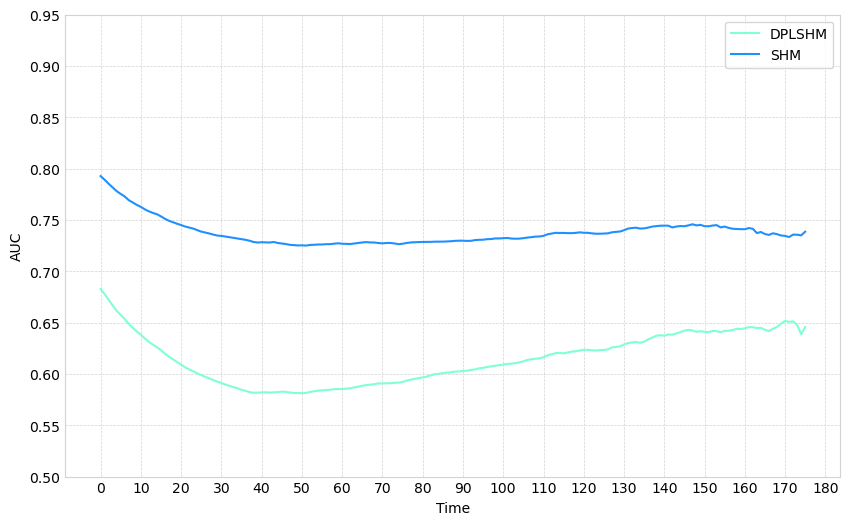

In [32]:
import numpy as np
import matplotlib.pyplot as plt

t = np.array(list(intersection))[:176]
plt.figure(figsize=(10, 6))  # 调整图像的横纵比

plt.plot(t, mean_auc_linear[:176], color='aquamarine', label='DPLSHM', linewidth=1.5)  # 调整线条粗细
plt.plot(t, mean_auc_DP[:176], color='dodgerblue', label='SHM', linewidth=1.5)
plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(0, 190, 10))
plt.ylim(0.5, 0.95)
plt.legend()

# 添加纵轴标题
plt.ylabel('AUC')

# 添加横轴标题
plt.xlabel('Time')

# 去掉刻度值旁边的小短横
plt.tick_params(axis='both', which='both', length=0)

# 更改图像框的颜色为浅灰色
ax = plt.gca()
ax.spines['top'].set_color('lightgrey')
ax.spines['bottom'].set_color('lightgrey')
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
plt.savefig('auc', dpi=1000)

In [ ]:
t[0:172]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
x_linear = np.arange(0.9, 5, 1)  # x 坐标
y_linear = np.array([0.2656, 0.3669, 0.3861, 0.2252, 0.3345])  # y 坐标
conf_intervals_linear = np.array([0.343, 0.3404, 0.3444, 0.3497, 0.3151])  # 置信区间长度
x_DP = np.arange(1.1, 6, 1)
y_DP = np.array([0.1848, 0.2484, 0.3208, 0.1528, 0.1538])
conf_intervals_DP = np.array([0.3148, 0.3021, 0.3346, 0.3106, 0.3099])

# 绘制误差线图
plt.errorbar(x_linear, y_linear, yerr=conf_intervals_linear, fmt='o', capsize=5, color='aquamarine', marker='s', markersize=8, label='Linear')
plt.errorbar(x_DP, y_DP, yerr=conf_intervals_DP, fmt='o', capsize=5, color='dodgerblue', marker='^', markersize=8, label='DP')
plt.axhline(y=0, color='lightgrey',linewidth=1)

# 设置坐标轴标签
plt.xlabel('Fold')

# 添加图例
plt.legend()
plt.figure(dpi=2000)
# 显示图形
plt.show()

In [ ]:
np.arange(1.1, 6, 1)